In [1]:
#imports
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc, accuracy_score, r2_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

In [2]:
#reading the preprocessed data - (output of phase 1)
data = pd.read_csv('../data/processed/cleaned_data.csv')

In [3]:
#checking data entry upto 2022
data.tail(5)

,raceId,season,raceNumber,prixName,raceDate,driverId,constructorId,driverStartGridPos,driverFinalGridPos,driverFinalRank,driverRacePoints,driverLapCount,driverFatestLapNumber,driverFastestLapTime,driverFastestLapSpeed,constructorRacePoints,driverNumber,driverDateOfBirth,driverNationality,constructorName,constructorNationality,constructorChampionshipStandingPoints,constructorChampionshipStandingPosition,constructorChampionshipStandingWins,driverChampionshipStandingPoints,driverChampionshipStandingPosition,driverChampionshipStandingWins,circuitName,circuitLocation,circuitCountry,driverRaceResultStatus,driverName,driverAge,driverDnf,constructorDnf
6990,1096,2022,22,Abu Dhabi Grand Prix,2022-11-20,854,210,12,16.0,16,0.0,57.0,39.0,1:29.833,211.632,0.0,47.0,1999-03-22,German,Haas F1 Team,American,37.0,8.0,0.0,12.0,16.0,0.0,Yas Marina Circuit,Abu Dhabi,UAE,+1 Lap,Mick Schumacher,24.0,0,1
6991,1096,2022,22,Abu Dhabi Grand Prix,2022-11-20,825,210,16,17.0,17,0.0,57.0,40.0,1:31.158,208.556,0.0,20.0,1992-10-05,Danish,Haas F1 Team,American,37.0,8.0,0.0,25.0,13.0,0.0,Yas Marina Circuit,Abu Dhabi,UAE,+1 Lap,Kevin Magnussen,30.0,0,1
6992,1096,2022,22,Abu Dhabi Grand Prix,2022-11-20,1,131,5,18.0,18,0.0,55.0,42.0,1:29.788,211.738,10.0,44.0,1985-01-07,British,Mercedes,German,515.0,3.0,1.0,240.0,6.0,0.0,Yas Marina Circuit,Abu Dhabi,UAE,Hydraulics,Lewis Hamilton,38.0,0,1
6993,1096,2022,22,Abu Dhabi Grand Prix,2022-11-20,849,3,20,19.0,19,0.0,55.0,45.0,1:30.309,210.517,0.0,6.0,1995-06-29,Canadian,Williams,British,8.0,10.0,0.0,2.0,20.0,0.0,Yas Marina Circuit,Abu Dhabi,UAE,Collision damage,Nicholas Latifi,28.0,0,1
6994,1096,2022,22,Abu Dhabi Grand Prix,2022-11-20,4,214,10,0.0,20,0.0,27.0,24.0,1:30.579,209.889,6.0,14.0,1981-07-29,Spanish,Renault,French,173.0,4.0,0.0,81.0,9.0,0.0,Yas Marina Circuit,Abu Dhabi,UAE,Water leak,Fernando Alonso,42.0,0,1


In [4]:
#checking all features present
data.columns

Index(['raceId', 'season', 'raceNumber', 'prixName', 'raceDate', 'driverId',
       'constructorId', 'driverStartGridPos', 'driverFinalGridPos',
       'driverFinalRank', 'driverRacePoints', 'driverLapCount',
       'driverFatestLapNumber', 'driverFastestLapTime',
       'driverFastestLapSpeed', 'constructorRacePoints', 'driverNumber',
       'driverDateOfBirth', 'driverNationality', 'constructorName',
       'constructorNationality', 'constructorChampionshipStandingPoints',
       'constructorChampionshipStandingPosition',
       'constructorChampionshipStandingWins',
       'driverChampionshipStandingPoints',
       'driverChampionshipStandingPosition', 'driverChampionshipStandingWins',
       'circuitName', 'circuitLocation', 'circuitCountry',
       'driverRaceResultStatus', 'driverName', 'driverAge', 'driverDnf',
       'constructorDnf'],
      dtype='object')

In [5]:
#selecting features depending on correlation matrix from EDA performed in Phase 1
features = ['season','driverId','constructorId', 'driverStartGridPos', 
            'driverFinalGridPos', 'driverChampionshipStandingPosition', 
            'constructorChampionshipStandingPosition']

#Dropping unnecessary features and setting target variable - driver ranking in each race
X = data[features]
y = data['driverFinalRank']

# split dataset into training(80%) and testing sets (20%) and stratifying over season
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=data['season'])

# Scale the features to ensure all features are at same scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Defining the MLP regressor
model = MLPRegressor()

# Define the parameter grid for GridSearchCV
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100)],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive']
}

# Perform GridSearchCV to find the best parameters for the model
grid_search = GridSearchCV(model, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)


# Use the best parameters to build the final model
best_model = MLPRegressor(**grid_search.best_params_)
best_model.fit(X_train_scaled, y_train)

# Predict the test set labels
y_pred = best_model.predict(X_test_scaled)

/Users/dhvani/opt/anaconda3/envs/DIC/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dhvani/opt/anaconda3/envs/DIC/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dhvani/opt/anaconda3/envs/DIC/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dhvani/opt/anaconda3/envs/DIC/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged ye

/Users/dhvani/opt/anaconda3/envs/DIC/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dhvani/opt/anaconda3/envs/DIC/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dhvani/opt/anaconda3/envs/DIC/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dhvani/opt/anaconda3/envs/DIC/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged ye

/Users/dhvani/opt/anaconda3/envs/DIC/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dhvani/opt/anaconda3/envs/DIC/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dhvani/opt/anaconda3/envs/DIC/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dhvani/opt/anaconda3/envs/DIC/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged ye

/Users/dhvani/opt/anaconda3/envs/DIC/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dhvani/opt/anaconda3/envs/DIC/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dhvani/opt/anaconda3/envs/DIC/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dhvani/opt/anaconda3/envs/DIC/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged ye

/Users/dhvani/opt/anaconda3/envs/DIC/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dhvani/opt/anaconda3/envs/DIC/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dhvani/opt/anaconda3/envs/DIC/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dhvani/opt/anaconda3/envs/DIC/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged ye

/Users/dhvani/opt/anaconda3/envs/DIC/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dhvani/opt/anaconda3/envs/DIC/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dhvani/opt/anaconda3/envs/DIC/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dhvani/opt/anaconda3/envs/DIC/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged ye

/Users/dhvani/opt/anaconda3/envs/DIC/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dhvani/opt/anaconda3/envs/DIC/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dhvani/opt/anaconda3/envs/DIC/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dhvani/opt/anaconda3/envs/DIC/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged ye

/Users/dhvani/opt/anaconda3/envs/DIC/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dhvani/opt/anaconda3/envs/DIC/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dhvani/opt/anaconda3/envs/DIC/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dhvani/opt/anaconda3/envs/DIC/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged ye

/Users/dhvani/opt/anaconda3/envs/DIC/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dhvani/opt/anaconda3/envs/DIC/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dhvani/opt/anaconda3/envs/DIC/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dhvani/opt/anaconda3/envs/DIC/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged ye

/Users/dhvani/opt/anaconda3/envs/DIC/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dhvani/opt/anaconda3/envs/DIC/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dhvani/opt/anaconda3/envs/DIC/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dhvani/opt/anaconda3/envs/DIC/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged ye

/Users/dhvani/opt/anaconda3/envs/DIC/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dhvani/opt/anaconda3/envs/DIC/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dhvani/opt/anaconda3/envs/DIC/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dhvani/opt/anaconda3/envs/DIC/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged ye

/Users/dhvani/opt/anaconda3/envs/DIC/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dhvani/opt/anaconda3/envs/DIC/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dhvani/opt/anaconda3/envs/DIC/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dhvani/opt/anaconda3/envs/DIC/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged ye

/Users/dhvani/opt/anaconda3/envs/DIC/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dhvani/opt/anaconda3/envs/DIC/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dhvani/opt/anaconda3/envs/DIC/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dhvani/opt/anaconda3/envs/DIC/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged ye

/Users/dhvani/opt/anaconda3/envs/DIC/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dhvani/opt/anaconda3/envs/DIC/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dhvani/opt/anaconda3/envs/DIC/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dhvani/opt/anaconda3/envs/DIC/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged ye

/Users/dhvani/opt/anaconda3/envs/DIC/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dhvani/opt/anaconda3/envs/DIC/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dhvani/opt/anaconda3/envs/DIC/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dhvani/opt/anaconda3/envs/DIC/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged ye

/Users/dhvani/opt/anaconda3/envs/DIC/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dhvani/opt/anaconda3/envs/DIC/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dhvani/opt/anaconda3/envs/DIC/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dhvani/opt/anaconda3/envs/DIC/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged ye

/Users/dhvani/opt/anaconda3/envs/DIC/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dhvani/opt/anaconda3/envs/DIC/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dhvani/opt/anaconda3/envs/DIC/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dhvani/opt/anaconda3/envs/DIC/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged ye

/Users/dhvani/opt/anaconda3/envs/DIC/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dhvani/opt/anaconda3/envs/DIC/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dhvani/opt/anaconda3/envs/DIC/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dhvani/opt/anaconda3/envs/DIC/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged ye

/Users/dhvani/opt/anaconda3/envs/DIC/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dhvani/opt/anaconda3/envs/DIC/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dhvani/opt/anaconda3/envs/DIC/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dhvani/opt/anaconda3/envs/DIC/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged ye

In [6]:
# Print the best parameters found
print("Best parameters: ", grid_search.best_params_)

Best parameters:  {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (100, 100), 'learning_rate': 'adaptive', 'solver': 'sgd'}


In [7]:
# Calculate r2 score
r2 = r2_score(y_test, y_pred)
print("r2 score: {:.2f}%".format(r2*100))

r2 score: 97.68%


/Users/dhvani/opt/anaconda3/envs/DIC/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dhvani/opt/anaconda3/envs/DIC/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dhvani/opt/anaconda3/envs/DIC/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dhvani/opt/anaconda3/envs/DIC/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged ye

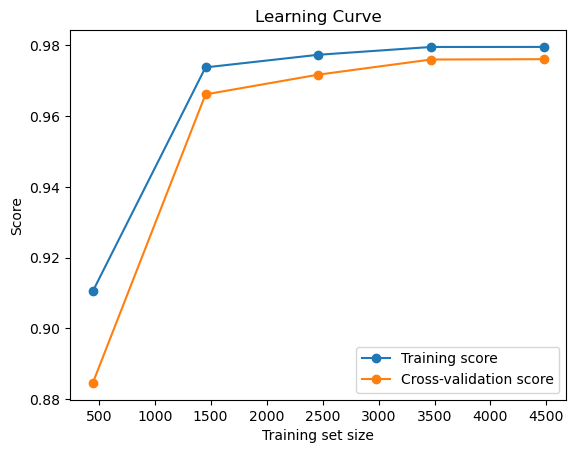

In [8]:
train_sizes, train_scores, test_scores = learning_curve(best_model, X_train_scaled, y_train, cv=5)
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
plt.plot(train_sizes, train_scores_mean, 'o-', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', label='Cross-validation score')
plt.xlabel('Training set size')
plt.ylabel('Score')
plt.title('Learning Curve')
plt.legend()
plt.show()

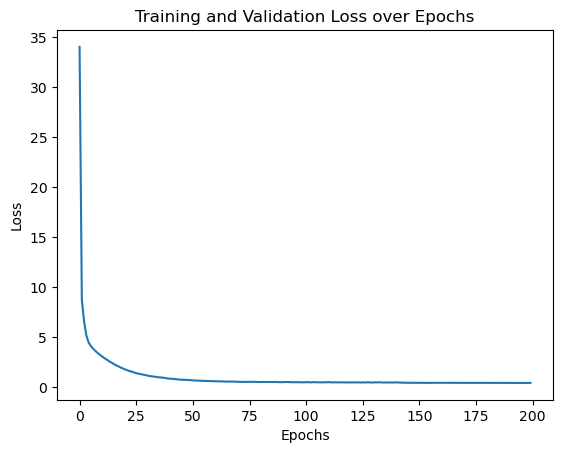

In [12]:
plt.plot(best_model.loss_curve_)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss over Epochs")
plt.show()


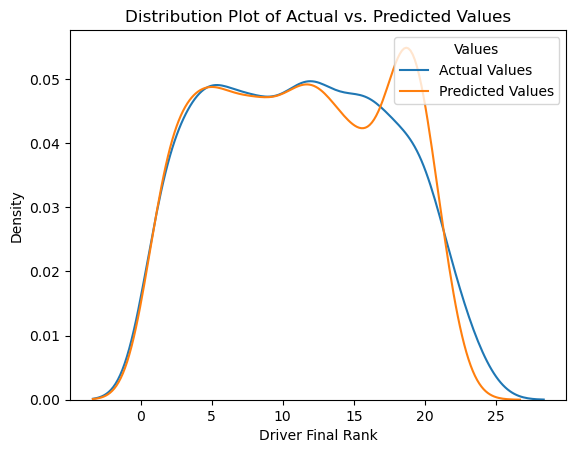

In [14]:
sns.kdeplot(y_test, label="Actual Values")
sns.kdeplot(y_pred, label="Predicted Values")
plt.xlabel("Driver Final Rank")
plt.ylabel("Density")
plt.title("Distribution Plot of Actual vs. Predicted Values")
plt.legend(title="Values", loc="upper right", labels=["Actual Values", "Predicted Values"])
plt.show()
